In [1]:
!pip install pyclesperanto_prototype 

In [1]:
from skimage import io
import matplotlib.pyplot as plt
# import scanpy
import numpy as np
import cupy as cp
import pyclesperanto_prototype as cle
cle.select_device('cuda')
from cupyx.scipy import ndimage
import os
import time
import pickle
import pandas as pd
import scanpy

In [2]:
img=io.imread('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/13months_disease-ADmouse_11346.tif')
img.shape

(30, 22578, 22465)

In [4]:
img2d=io.imread('/mnt/external_ssd/xinyi/starmap_new/2022-06-14-Xinyi-mAD/13months_disease-ADmouse_11346/2D/pi.tif')
img2d.shape

(22578, 22465)

In [3]:
voxel_size_x = 0.0946
voxel_size_y = 0.0946
voxel_size_z = 0.3463

s='ADmouse_11346'
sname='disease13'

In [4]:
#crop full image into patches with centered on each cell
datadir='/mnt/external_ssd/xinyi/starmap_new/2022-06-14-Xinyi-mAD'
plot_samples={'disease13old':'ADmouse_9494','control13old':'ADmouse_9498','disease8old':'ADmouse_9723','control8old':'ADmouse_9735','disease13':'ADmouse_11346','control13':'ADmouse_11351','disease8':'ADmouse_9723_2','control8':'ADmouse_9707'}
plot_samples_old={'disease13old':'AD_mouse9494','control13old':'AD_mouse9498','disease8old':'AD_mouse9723','control8old':'AD_mouse9735'}

olddata=scanpy.read_h5ad('/home/xinyiz/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
oldgenes=olddata.var.index.to_numpy()

gaeCoord=None
sampleNames=None
celltype_broad=None
celltype_sub=None
scaleddata=scanpy.read_h5ad(datadir+'/2022-04-06-Hu-AD-stardist-scaled.h5ad')
for s in plot_samples.keys():
    if 'old' in s:
        sampleidx_s=plot_samples_old[s]
    else:
        sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        if 'old' in s:
            gaeCoord=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
            sampleNames=np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))
            celltype_broad=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
            celltype_sub=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()
        else:
            gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
            sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type']].to_numpy()
    else:
        if 'old' in s:
            gaeCoord=np.concatenate((gaeCoord,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))),axis=None)
            celltype_broad=np.concatenate((celltype_broad,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
            celltype_sub=np.concatenate((celltype_sub,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()))
        else:
            gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type']].to_numpy()))
celltype_broad=celltype_broad.flatten()
# gaeCoord=(gaeCoord/0.3).astype(int)
#by samples
gaeCoord=gaeCoord[sampleNames==sname]
# scaleddata=None

In [5]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/newold/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.082epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)
gaeclusterlabels=gaeclusterlabels[sampleNames==sname]

In [6]:
stats=np.zeros((gaeCoord.shape[0],35))
cropsize=200
minmaxsize=400 #consistent with clf/grad/... inputs
outline_sigma=3
maxiter=100
maxiter_opt=10
clusters=['0','3','2']

In [7]:
spot_sigma_start=40
maxstep=10
mindiff=0.1
minarea=10000
timer=time.time()
for i in range(gaeCoord.shape[0]):
    if not (str(gaeclusterlabels[i]) in clusters):
        continue
    testcoord=gaeCoord[i]
    
    if testcoord[0]-minmaxsize<0:
        centroidx=testcoord[0]
    else:
        centroidx=minmaxsize
    if testcoord[1]-minmaxsize<0:
        centroidy=testcoord[1]
    else:
        centroidy=minmaxsize
    
#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
    testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
    testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
    testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
    input_gpu = cle.push(testinput)
    resampled = cle.create([int(input_gpu.shape[0]*voxel_size_z/voxel_size_x), input_gpu.shape[1],input_gpu.shape[2] ])
    cle.scale(input_gpu, resampled, factor_x=1, factor_y=1, factor_z=voxel_size_z/voxel_size_x, centered=False)
#     resampled_erode=ndimage.grey_erosion(cp.array(resampled),structure=cp.ones((10,10,10)))
    
    if testcoord[0]-cropsize<0:
        centroidx=testcoord[0]
    else:
        centroidx=cropsize
    if testcoord[1]-cropsize<0:
        centroidy=testcoord[1]
    else:
        centroidy=cropsize
    
    area=0
    prevsigma=spot_sigma_start
    currsigma=spot_sigma_start
    niter=0
    cellfound=True
    while area<minarea:
        #first pass: no erosion
        segmented = cle.voronoi_otsu_labeling(resampled, spot_sigma=currsigma, outline_sigma=outline_sigma)
#         currstats= cle.statistics_of_labelled_pixels(resampled_erode,segmented)
#         minx=currstats['bbox_min_y']<centroidx   #(z,y,x in cle)
#         maxx=currstats['bbox_max_y']>centroidx
#         miny=currstats['bbox_min_x']<centroidy   #(z,y,x in cle)
#         maxy=currstats['bbox_max_x']>centroidy
#         label=np.arange(minx.size)[np.logical_and(np.logical_and(minx,maxx),np.logical_and(miny,maxy))]
        cellexist=cp.sum(cp.array(segmented)[:,centroidx,centroidy])>0
        if not cellexist:
            currsigma=currsigma-min(maxstep,currsigma/2)
        else:
            break
        if niter>maxiter:
            print('cannot find cell')
            print(i)
            print(gaeCoord[i])
#             print(currstats)
            cellfound=False
            break
        niter+=1
        prevsigma=currsigma
    if not cellfound:
        continue
    niter=0
    while prevsigma>currsigma+mindiff and cellfound:
        segmentednew = cle.voronoi_otsu_labeling(resampled, spot_sigma=(prevsigma+currsigma)/2, outline_sigma=outline_sigma)
        cellexist=cp.sum(cp.array(segmentednew)[:,centroidx,centroidy])>0
        
        if not cellexist:
            prevsigma=(prevsigma+currsigma)/2
        else:
            currsigma=(prevsigma+currsigma)/2
            segmented=segmentednew
        niter+=1
        if niter>maxiter:
            break
    currstats= cle.statistics_of_labelled_pixels(resampled,segmented)
    minx=currstats['bbox_min_y']<=centroidx   #(z,y,x in cle)
    maxx=currstats['bbox_max_y']>=centroidx
    miny=currstats['bbox_min_x']<=centroidy   #(z,y,x in cle)
    maxy=currstats['bbox_max_x']>=centroidy
    label=np.arange(minx.size)[np.logical_and(np.logical_and(minx,maxx),np.logical_and(miny,maxy))]
    if label.size==0:
        print(i)
        print(testcoord)
        print(currstats)
    label=label[0]
    segmented=segmented==int(label+1)
    segmented=cp.array(segmented)
    segmented=ndimage.binary_fill_holes(segmented,structure=cp.ones((2,2,3)))
    currstats=pd.DataFrame(currstats).to_numpy()
    if not os.path.exists('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+sname+'/'):
        os.mkdir('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+sname+'/')
    with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+sname+'/'+str(i),'wb') as outputseg:
        pickle.dump(segmented,outputseg)
    stats[i]=currstats[label,2:].flatten()
    if i%100==0:
        print(str('processed')+str(i))
        print(time.time()-timer)
            
#     dilate


size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109


size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109


size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109


size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109


size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
6482
[14412 16555]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
processed6500
10640.202365636826
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
s

size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
6806
[15195 14297]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size

size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
6949
[15554 19127]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size

size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
7097
[15820 20099]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
processed7100
19099.48658823967
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
si

size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
7309
[16322 18231]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size

size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
cannot find cell
7377
[16375 20834]
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size: 109
size

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/'+sname+'/'+'stats','wb') as outputseg:
    pickle.dump(stats,outputseg)

In [9]:
gaeCoord.shape

(9634, 2)

In [8]:

def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
#     plt.scatter(200,26,c='red')
    plt.show()



In [16]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/10','rb') as outputseg:
    segmented=pickle.load(outputseg)

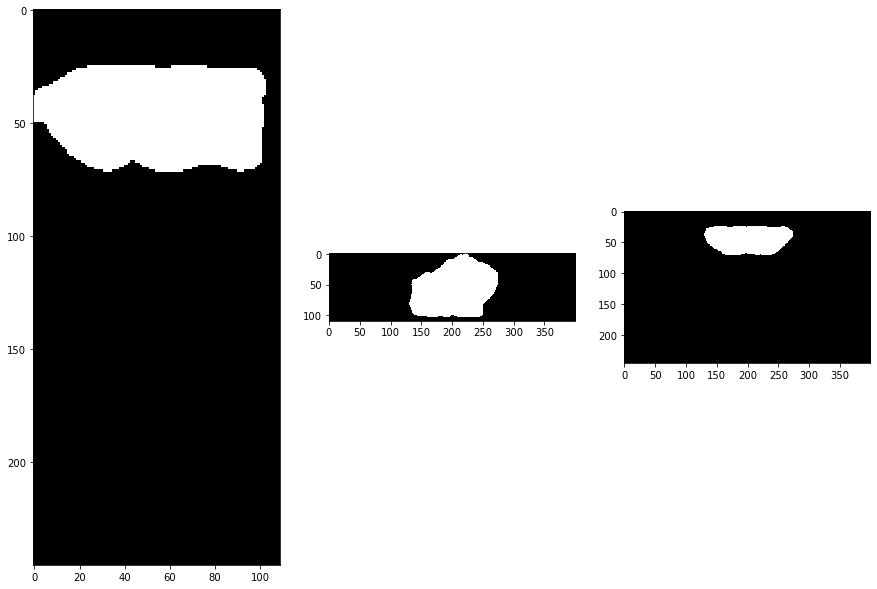

In [17]:
show(segmented)

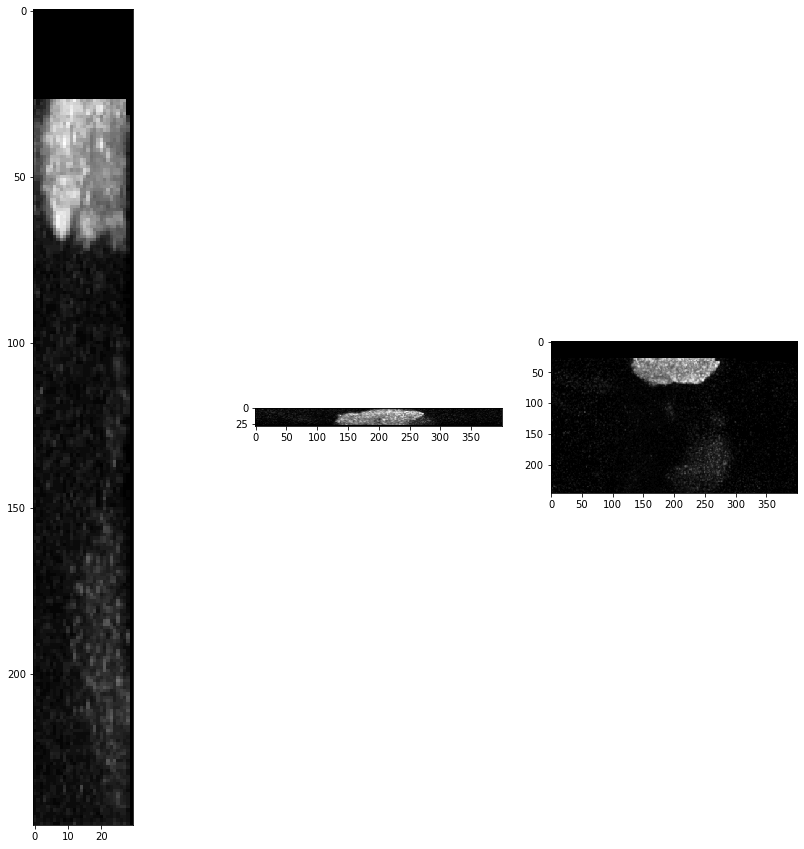

In [18]:
i=10
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

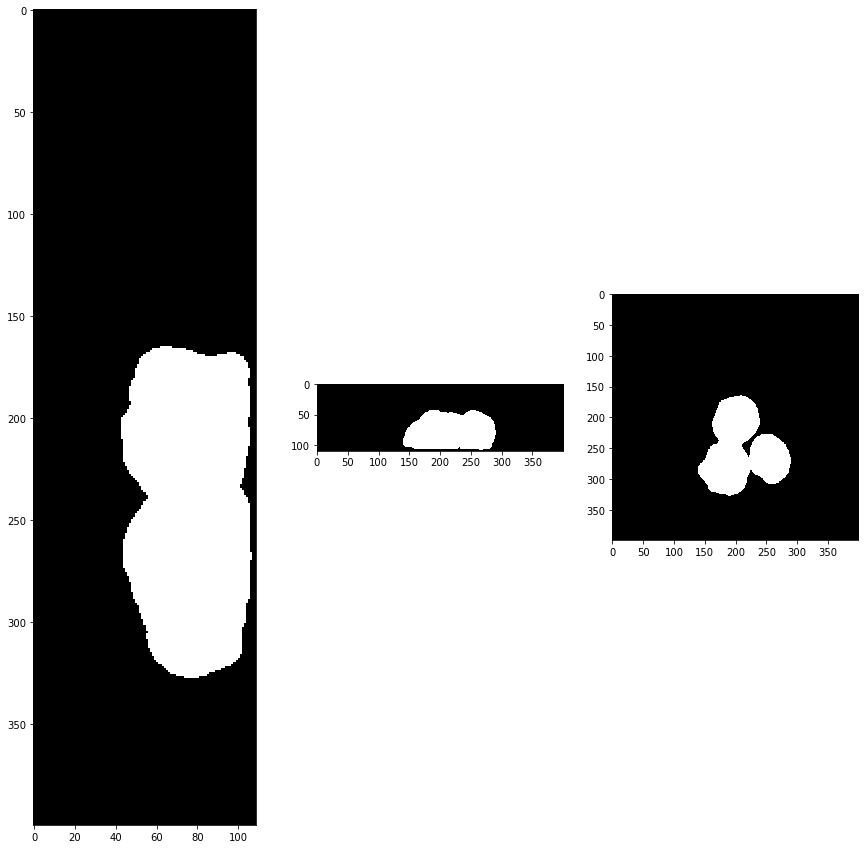

In [20]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/143','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

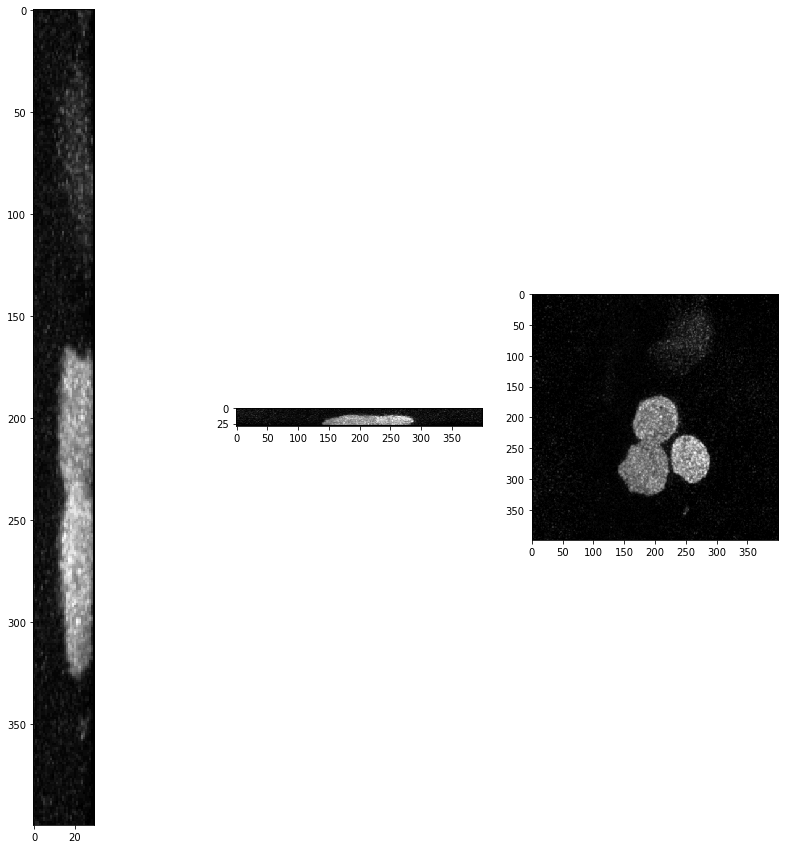

In [21]:
i=143
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

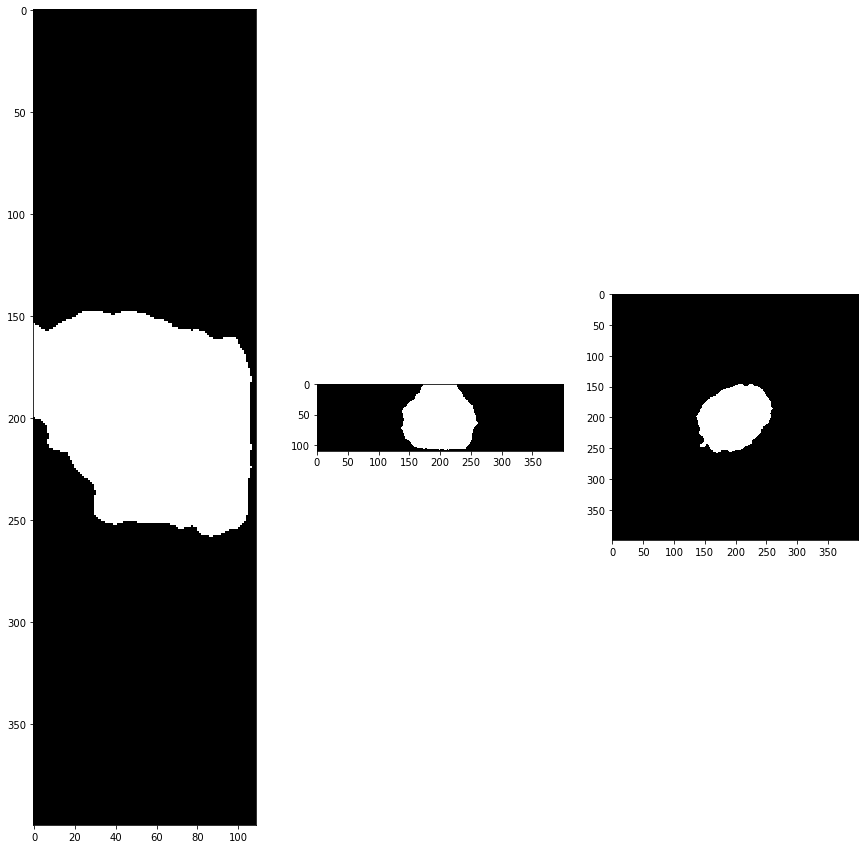

In [9]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/101','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

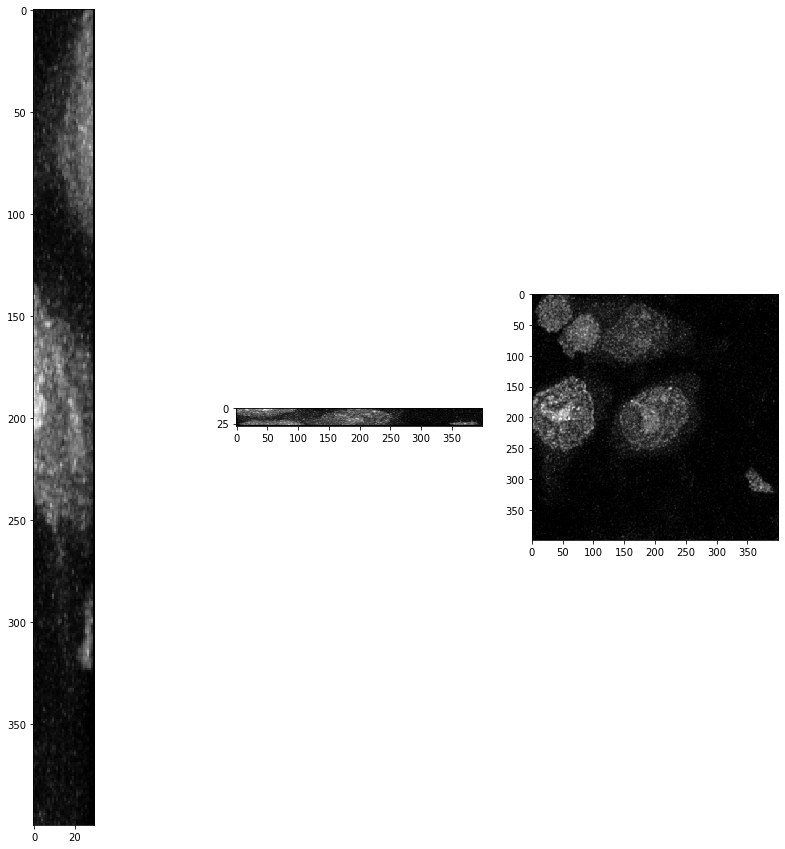

In [10]:
i=101
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

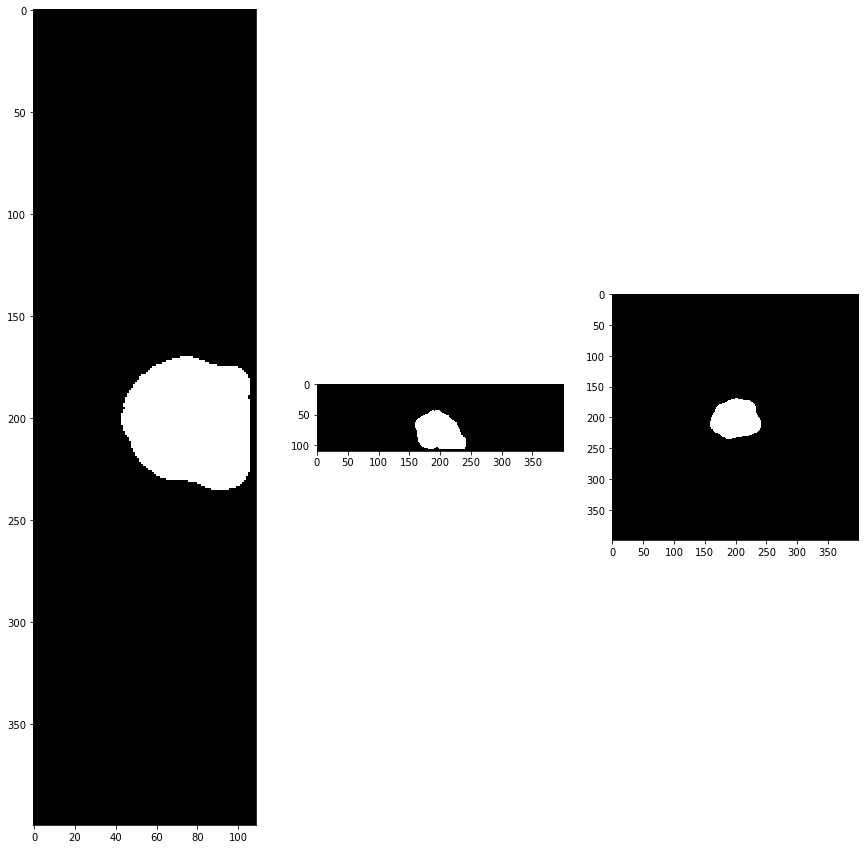

In [11]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/107','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

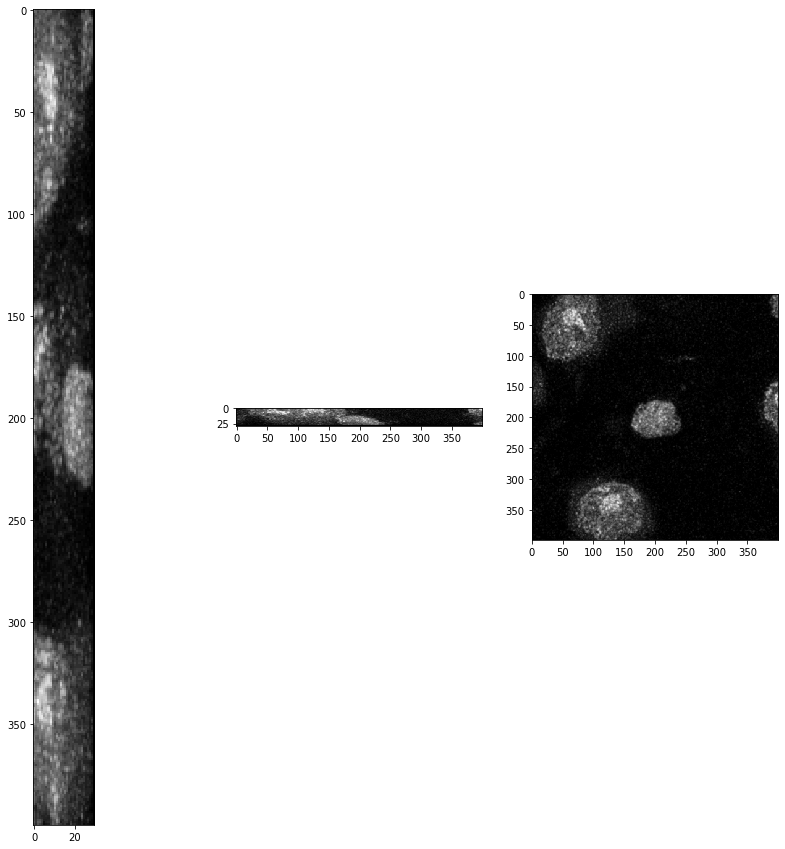

In [12]:
i=107
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

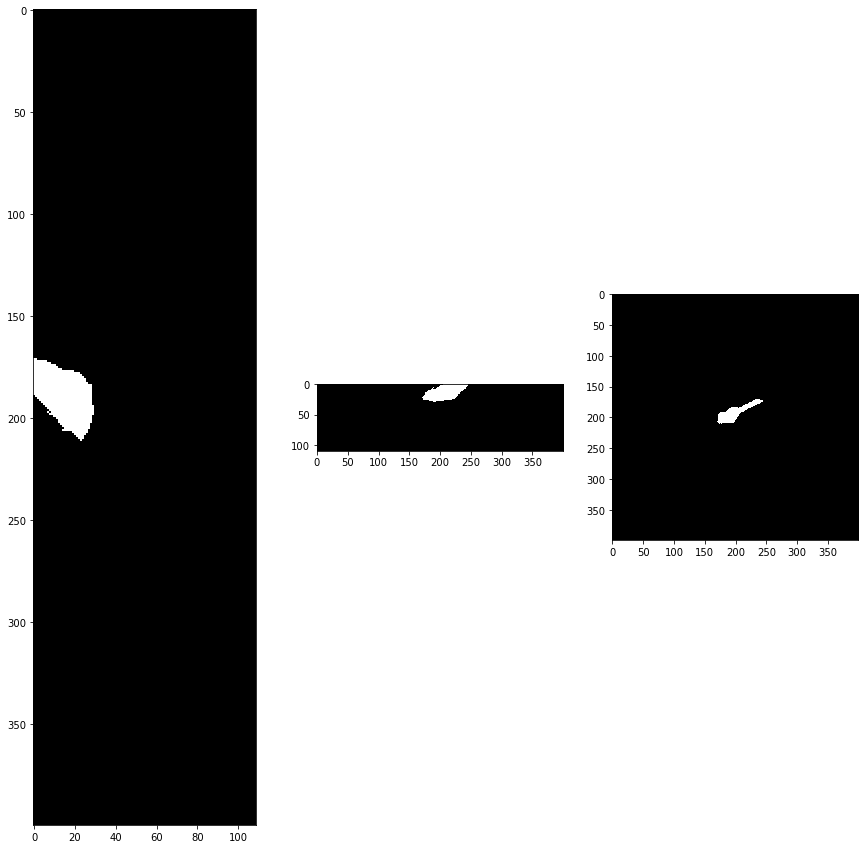

In [13]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/122','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

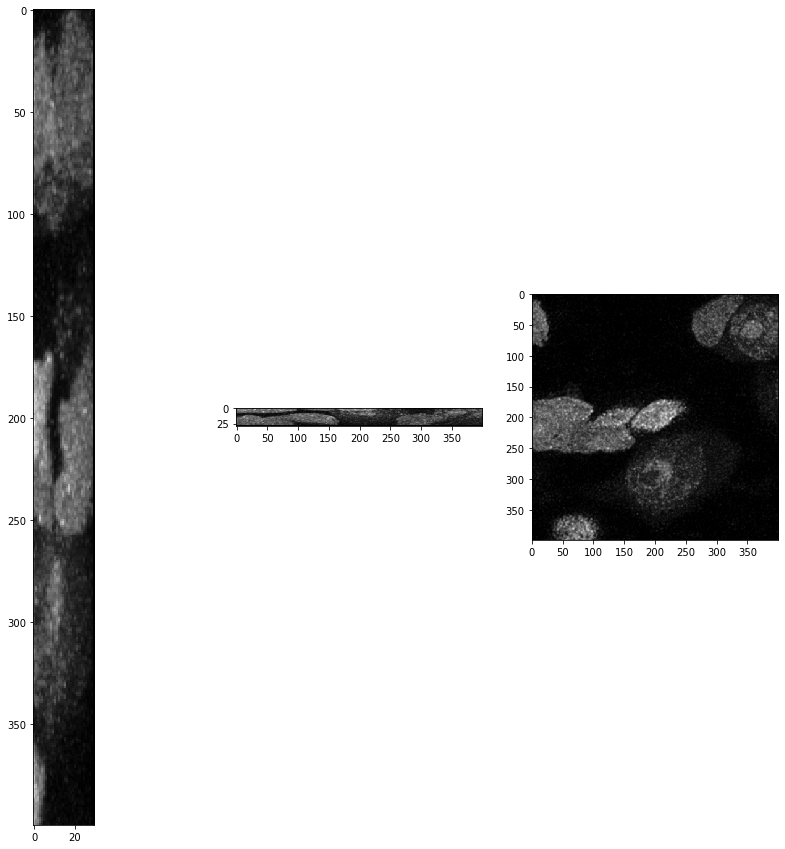

In [14]:
i=122
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

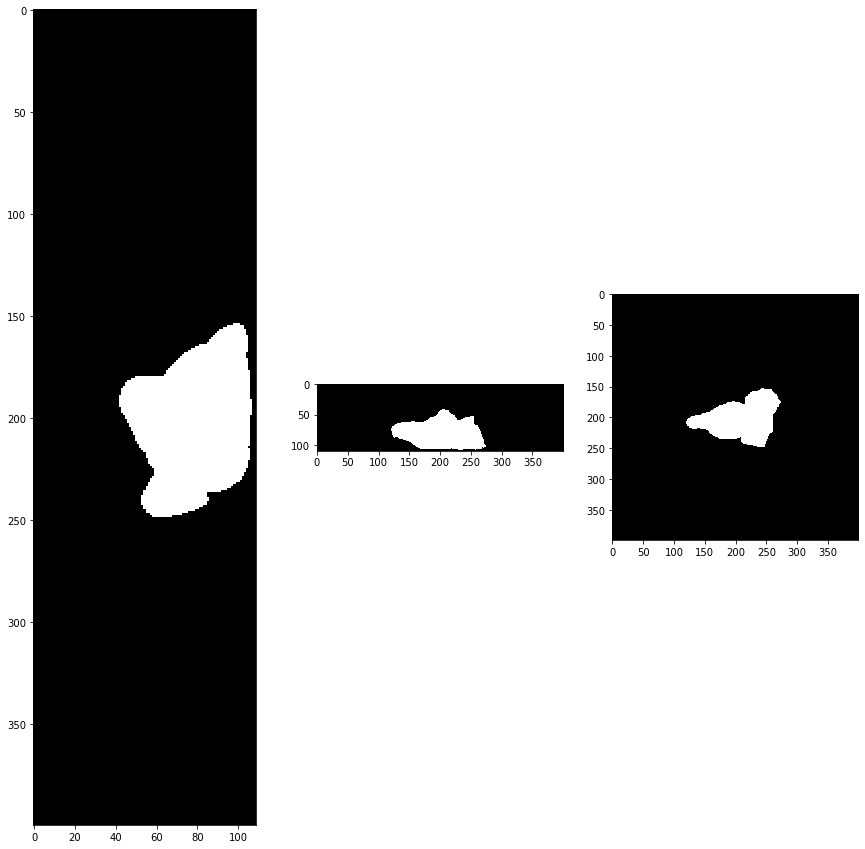

In [15]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/127','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

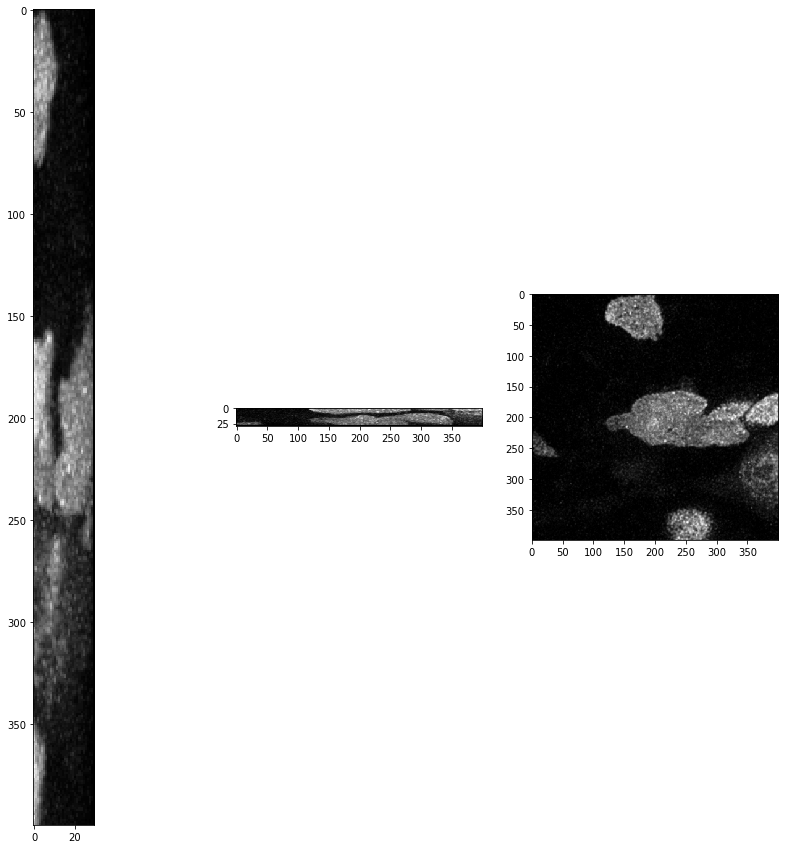

In [16]:
i=127
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

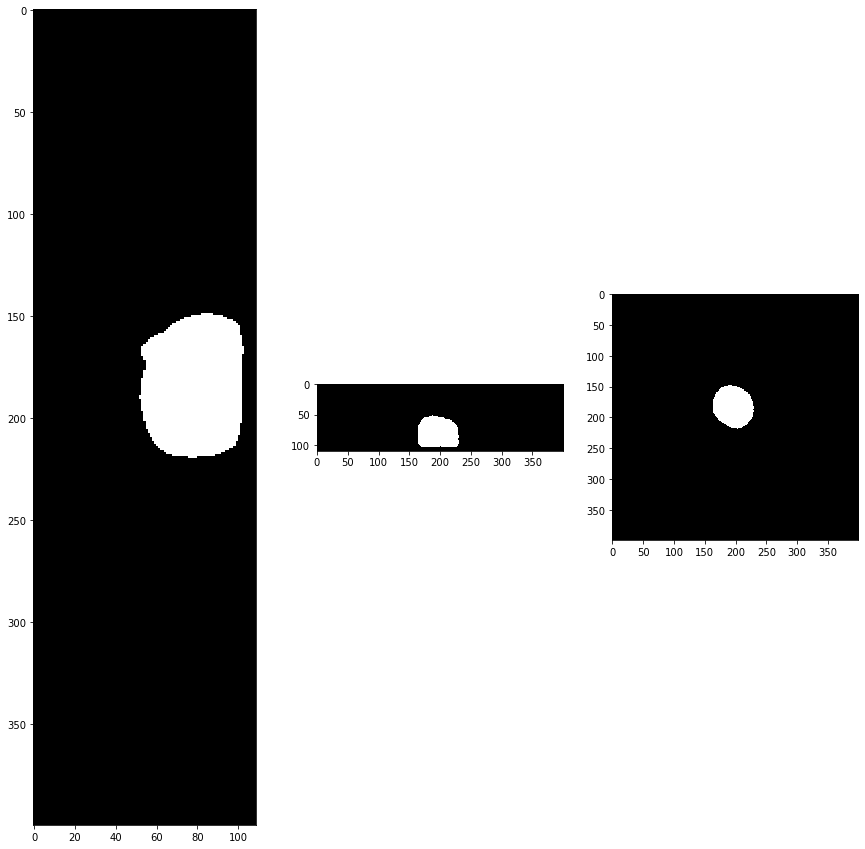

In [17]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/131','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

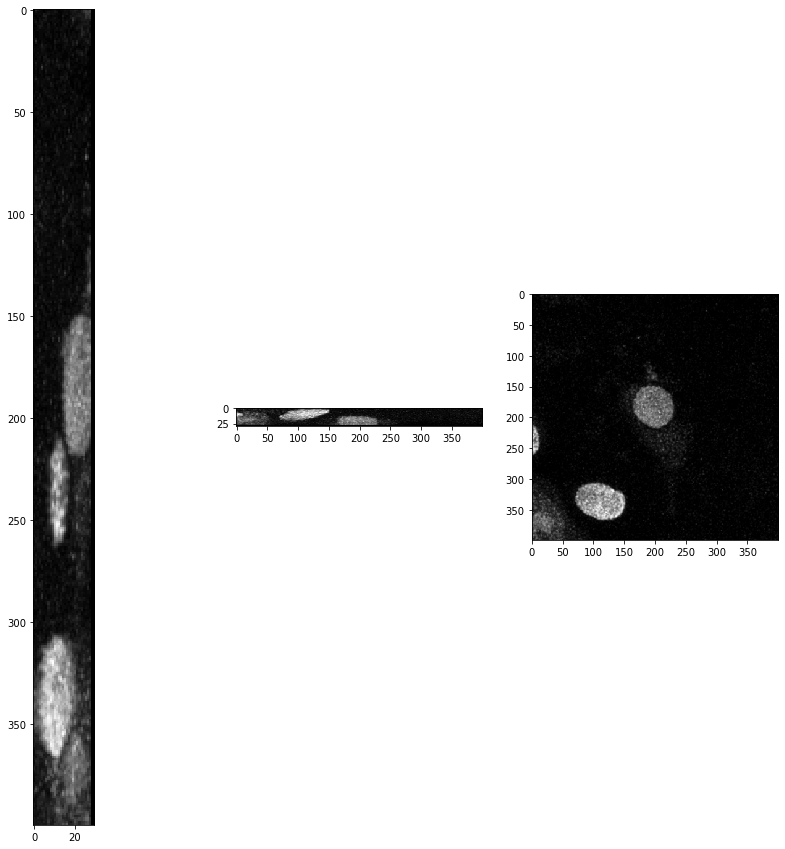

In [18]:
i=131
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

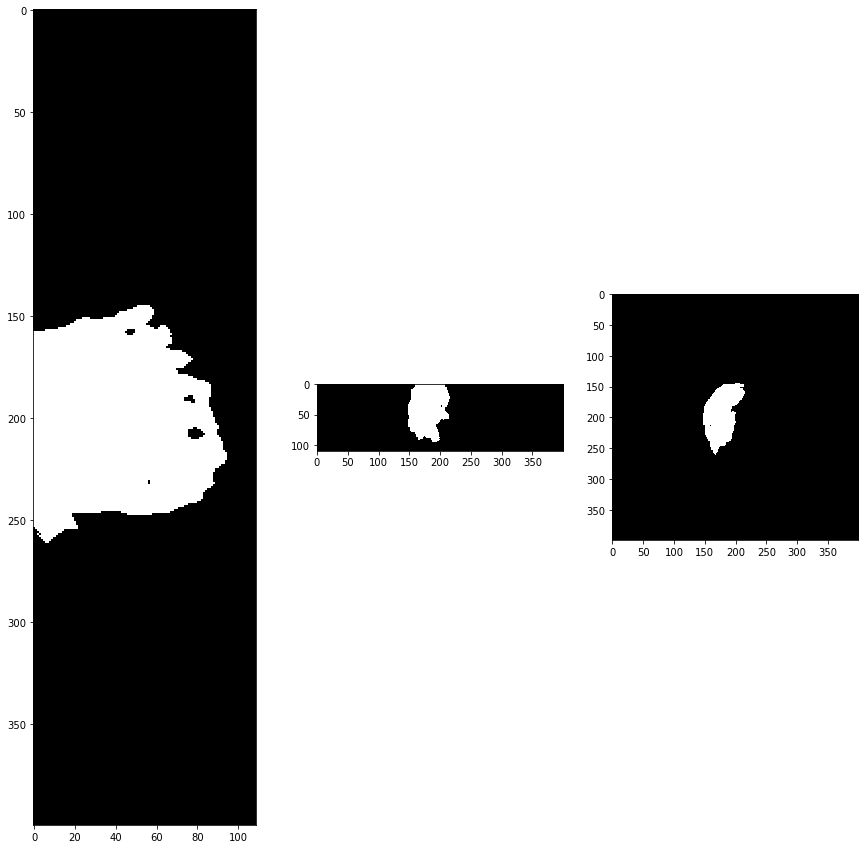

In [19]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/134','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

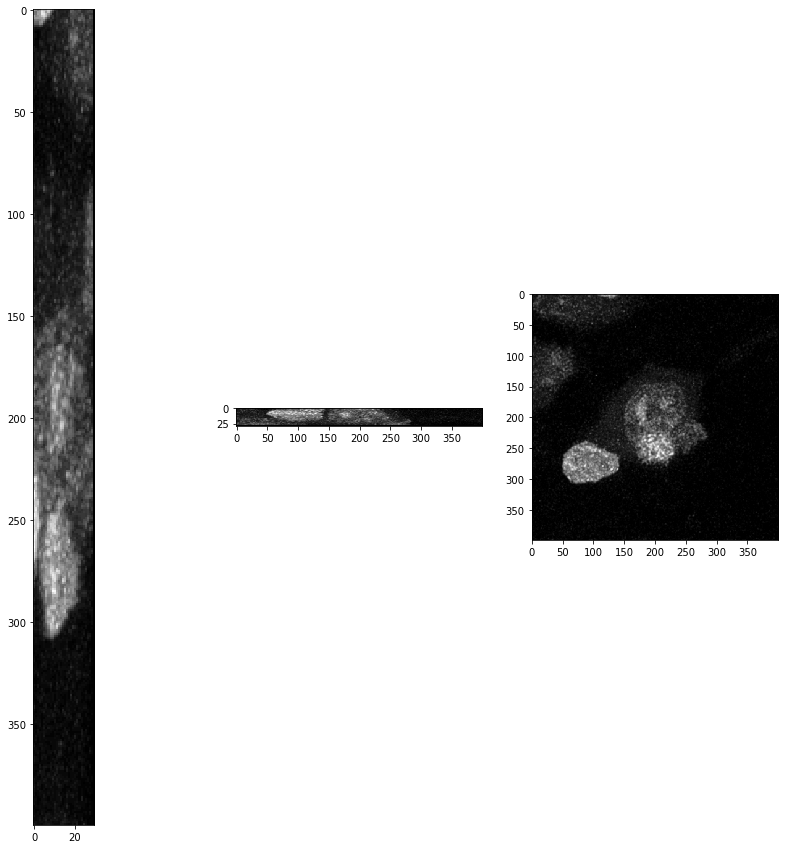

In [20]:
i=134
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

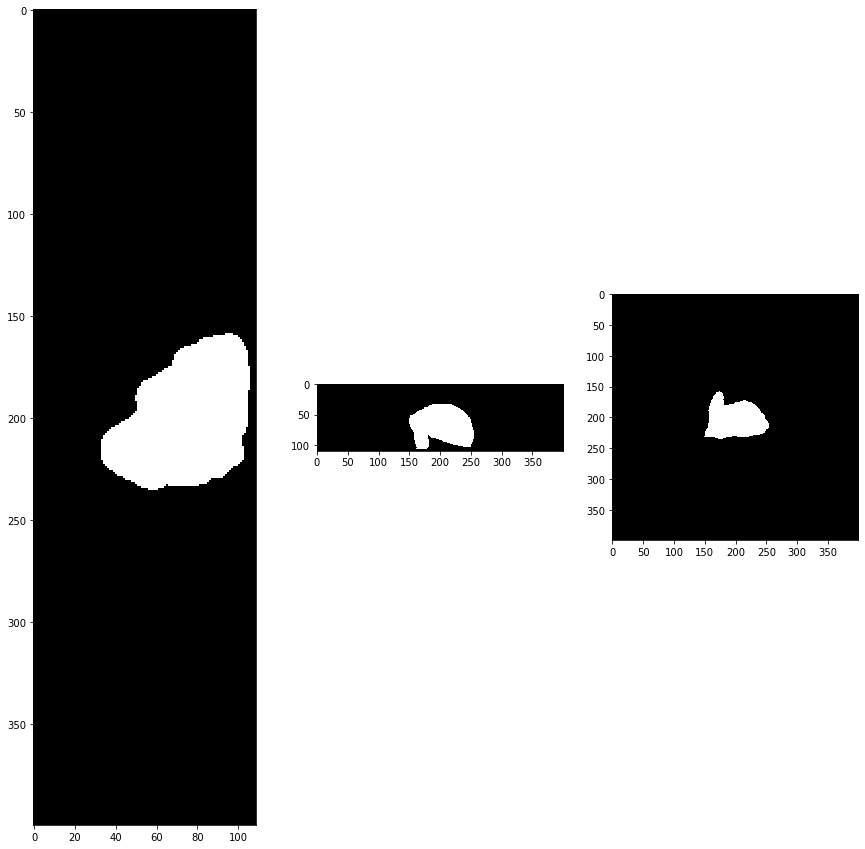

In [21]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/136','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

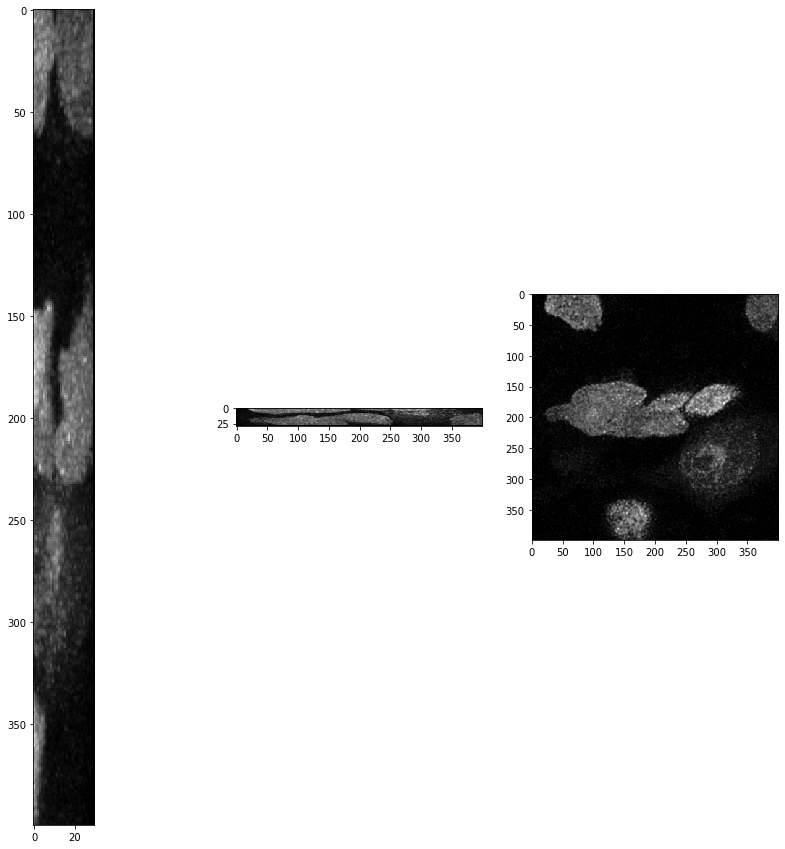

In [22]:
i=136
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

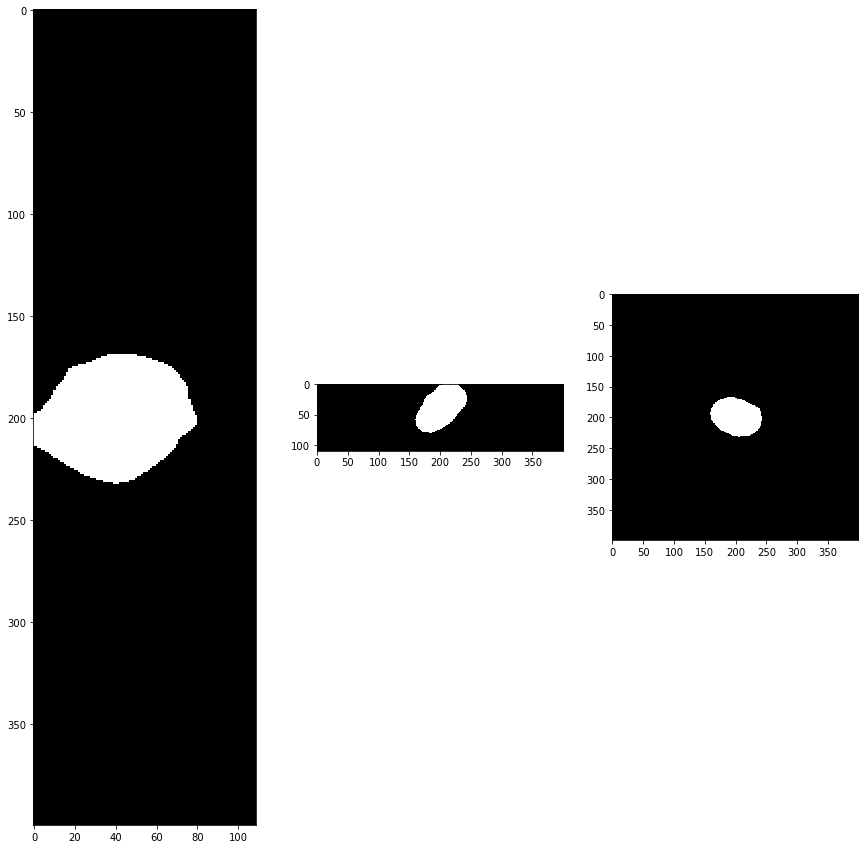

In [23]:
with open('/mnt/external_ssd/xinyi/2022-07-21-Xinyi-mAD-3D-pi/stats/disease13/202','rb') as outputseg:
    segmented=pickle.load(outputseg)
show(segmented)

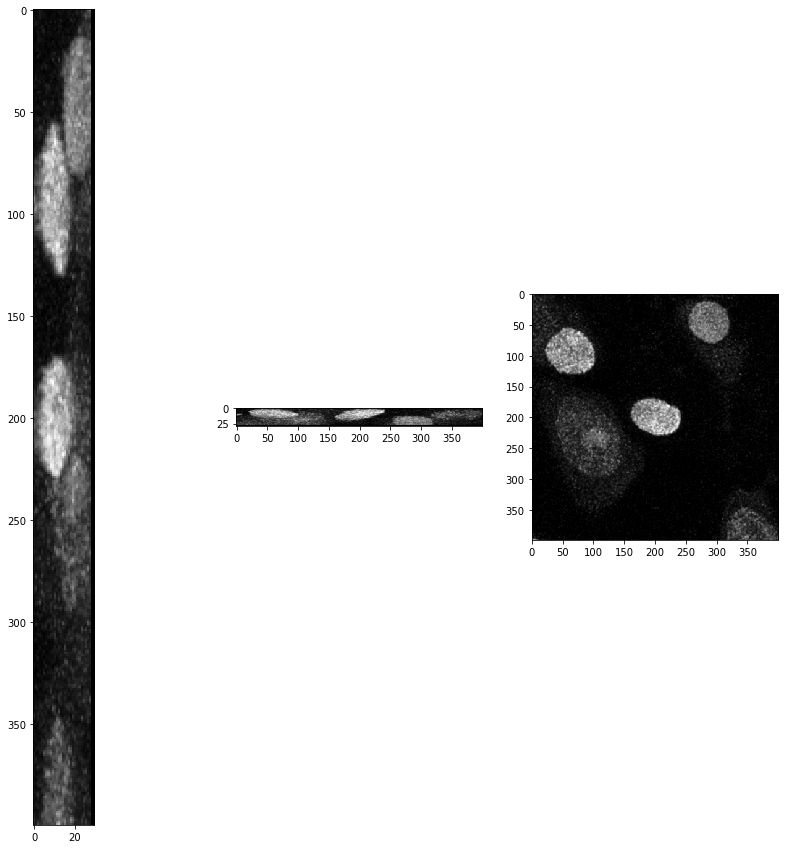

In [24]:
i=202
testcoord=gaeCoord[i]
    
if testcoord[0]-minmaxsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-minmaxsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

In [12]:
currstats= cle.statistics_of_labelled_pixels(resampled,segmented)

In [13]:
currstats=pd.DataFrame(currstats).to_numpy()

In [14]:
currstats

array([[1.00000000e+00, 1.00000000e+00, 1.68000000e+02, 1.60000000e+02,
        2.00000000e+00, 2.41000000e+02, 2.39000000e+02, 2.80000000e+01,
        7.40000000e+01, 8.00000000e+01, 2.70000000e+01, 0.00000000e+00,
        8.49557519e-01, 1.98624492e+04, 7.73680000e+04, 2.56726921e-01,
        3.97630800e+06, 2.00192230e+02, 3.96462175e+06, 1.99603867e+02,
        2.29710438e+05, 1.15650606e+01, 1.55083420e+07, 2.00449051e+02,
        1.54731180e+07, 1.99993774e+02, 9.48289000e+05, 1.22568636e+01,
        1.83846162e+06, 2.37625580e+01, 1.84032438e+06, 2.37866344e+01,
        1.25153825e-01, 4.34682388e+01, 4.36331558e+01, 1.82927442e+00,
        1.83435595e+00]])